In [1]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset

configs = {
    "sst2": {
        "globenc_path": lambda epoch : f"/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/sst2-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "mnli": {
        "globenc_path": lambda epoch : f"/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    }
}

CONFIG = configs["mnli"]  # sst2/mnli

In [2]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    print(f"Read {path}")
    return data

In [3]:
globencs = list()  # [epoch, {globenc, tokens}, #]
for epoch in tqdm(range(6)):
    data = load_pickle(CONFIG["globenc_path"](epoch))
    globencs.append(data)

  0%|          | 0/6 [00:00<?, ?it/s]

Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e0_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e1_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e2_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e3_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e4_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e5_train_bert-base-uncased.pickle


In [4]:
def torch_pearson(x1, x2): # 1D tensor, 1D tensor -> scalar (Pearson Correlation)
    m1 = x1.mean()
    m2 = x2.mean()
    d1 = x1 - m1
    d2 = x2 - m2
    Cxy = torch.sum(d1*d2)
    Cxx = torch.sum(d1*d1)
    Cyy = torch.sum(d2*d2)
    return Cxy/(Cxx*Cyy).sqrt()

def calc_pRSA(i, v1, v2): # Calculates pointwise RSA [index, Vectorspace1, Vectorspace2]
    mask = ~torch.nn.functional.one_hot(torch.tensor(i), v1.shape[0]).bool()
    sims_e0 = torch.nn.functional.cosine_similarity(v1[mask], v1[i], dim=1, eps=1e-08)
    sims_e1 = torch.nn.functional.cosine_similarity(v2[mask], v2[i], dim=1, eps=1e-08)
    return torch_pearson(sims_e0, sims_e1)

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [10]:
# all_cls_e0 = torch.tensor(globencs[epoch_i]["cls"]).cuda()
# all_cls_e1 = torch.tensor(globencs[epoch_i+1]["cls"]).cuda()
all_cls = [torch.tensor(globencs[i]["cls"]).cuda() for i in range(len(globencs))]
# pRSA = np.zeros(all_cls[0].shape[0])
# pearsons = np.zeros(all_cls[0].shape[0])

/home/modaresi/.conda/envs/globenc-venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in tqdm(range(all_cls_e0.shape[0])):
    pRSA[i] = calc_pRSA(i, all_cls_e0, all_cls_e1).cpu()
    pearsons[i] = pearsonr(globencs[epoch_i]["globenc"][i][0], globencs[epoch_i+1]["globenc"][i][0])[0]

In [97]:
def get_nonoutlier_range(x):
    Q_1 = np.quantile(x, 0.25)
    Q_3 = np.quantile(x, 0.75)
    IQR = Q_3 - Q_1
    min_whisker = max(x.min(), Q_1 - 1.5 * IQR)
    max_whisker = min(x.max(), Q_3 + 1.5 * IQR)
    return min_whisker, max_whisker

In [ ]:
plt.scatter(pRSA, pearsons, s=.01)
plt.xlim(get_nonoutlier_range(pRSA))
plt.ylim(get_nonoutlier_range(pearsons))
plt.show()

In [5]:
def load_logits(dir_path: str):
    file_list = os.listdir(dir_path)
    file_list.sort()
    print("Loading files in:", dir_path)
    idxs, logits = [], []
    for file_name in file_list:
        print(file_name)
        file_path = f"{dir_path}/{file_name}"
        if "idxs" in file_path:
            idxs.append(np.array(torch.load(file_path)))
        elif "logits" in file_path:
            logits.append(np.array(torch.load(file_path)))
        else:
            raise Exception("Wrong Files!")
    logits_ordered = np.zeros(np.array(logits).shape)
    for epoch in range(len(idxs)):
        logits_ordered[epoch][idxs[epoch]] = logits[epoch]
    return logits_ordered

def el2n(logits, labels):
    logits = torch.tensor(logits)  # (3, 392702, 3)
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=max(labels) + 1)  # (392702, 3)
    scores = []
    for epoch in range(len(logits)):
        errors = torch.nn.functional.softmax(logits[epoch], dim=-1) - labels
#         score = torch.linalg.vector_norm(errors, dim=-1, ord=2)
        score = np.linalg.norm(errors, ord=2, axis=-1)
        scores.append(score)
    return np.mean(np.array(scores), axis=0)

def cartography(logits, true_labels):
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    corr_probs = np.sum(probs * np.expand_dims(torch.nn.functional.one_hot(true_labels, num_classes=max(true_labels) + 1).numpy(), axis=0), axis=-1)
    confs = np.mean(corr_probs, axis=0)
    variabilities = np.std(corr_probs, axis=0)
    return confs, variabilities

In [6]:
logits = load_logits(CONFIG["logits_path"])
logits.shape

Loading files in: /home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch
epoch0_step012272_after_epoch_train_idxs_[392702].pt
epoch0_step012272_after_epoch_train_logits_[392702, 3].pt
epoch1_step024544_after_epoch_train_idxs_[392702].pt
epoch1_step024544_after_epoch_train_logits_[392702, 3].pt
epoch2_step036816_after_epoch_train_idxs_[392702].pt
epoch2_step036816_after_epoch_train_logits_[392702, 3].pt
epoch3_step049088_after_epoch_train_idxs_[392702].pt
epoch3_step049088_after_epoch_train_logits_[392702, 3].pt
epoch4_step061360_after_epoch_train_idxs_[392702].pt
epoch4_step061360_after_epoch_train_logits_[392702, 3].pt


(5, 392702, 3)

In [7]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
confs, vars = cartography(torch.tensor(logits), torch.tensor(ds['label']))

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [8]:
np.argsort(vars)[-10:]

array([ 37487, 187926, 161115, 326809,  44065, 120677, 330701,  24499,
       362215, 362144])

In [23]:
import json
from scipy.stats import pearsonr, spearmanr

for idx in np.argsort(vars)[-10:]:
    print("Example", idx, "-- Var:", vars[idx])
    print(json.dumps(ds[int(idx)], indent=4))
    for ep in range(5):
        pRSA = calc_pRSA(idx, all_cls[ep], all_cls[ep+1]).cpu().numpy()
        pearson = spearmanr(globencs[ep]["globenc"][idx][0], globencs[ep+1]["globenc"][idx][0])[0]
        cosine_sim = torch.nn.functional.cosine_similarity(all_cls[ep][idx].unsqueeze(dim=0), all_cls[ep+1][idx].unsqueeze(dim=0)).cpu().numpy()[0]
        print_globenc(globencs[ep]["globenc"][idx], globencs[ep]["tokens"][idx])
        print(f"Epoch {ep} -> {ep+1} :: GlobencPearson:", pearson, "pRSA:", pRSA, "Final logits:", logits[ep, idx], "Cosine Sim:", cosine_sim)
    print_globenc(globencs[ep+1]["globenc"][idx], globencs[ep]["tokens"][idx])
    print("")

Example 37487 -- Var: 0.47941832338884566
{
    "premise": "The Galleria provides a sheltered, much trafficked pedestrian passage from the Duomo to another holy entity, the revered 18th-century La Scala theater, high temple of opera.",
    "hypothesis": "The Galleria is a famous theater.",
    "label": 2,
    "idx": 37487
}


Epoch 0 -> 1 :: GlobencPearson: 0.6249152019734814 pRSA: 0.031778246 Final logits: [ 0.97247779  1.53830814 -2.84850645] Cosine Sim: 0.57342803


Epoch 1 -> 2 :: GlobencPearson: 0.924390995991366 pRSA: 0.8710373 Final logits: [-0.73839158  2.18780899 -1.35764551] Cosine Sim: 0.8916454


Epoch 2 -> 3 :: GlobencPearson: 0.9659574468085106 pRSA: -0.36018097 Final logits: [-2.83680439 -0.73915964  3.77764821] Cosine Sim: 0.5635483


Epoch 3 -> 4 :: GlobencPearson: 0.9843354918285538 pRSA: 0.8976991 Final logits: [-3.53070688 -2.02808309  5.8272047 ] Cosine Sim: 0.77067125


Epoch 4 -> 5 :: GlobencPearson: 0.9965464076472402 pRSA: 0.99112415 Final logits: [-3.47975612 -2.73228192  6.56798744] Cosine Sim: 0.94107497



Example 187926 -- Var: 0.4797660548812024
{
    "premise": "The direct health effects of nitrogen oxide gases and sulfur dioxide gases are also unquantified.",
    "hypothesis": "The health effects of nitrogen oxide gases and sulfur dioxide gases are also unknown but we have the reports of negative effects.",
    "label": 2,
    "idx": 187926
}


Epoch 0 -> 1 :: GlobencPearson: -0.20131752305665346 pRSA: -0.03383254 Final logits: [-0.53547639  2.95910287 -2.57176876] Cosine Sim: 0.210592


Epoch 1 -> 2 :: GlobencPearson: 0.9629776021080367 pRSA: 0.8114792 Final logits: [-1.21047223  2.3746767  -1.05661404] Cosine Sim: 0.8526237


Epoch 2 -> 3 :: GlobencPearson: 0.9515151515151515 pRSA: -0.25232878 Final logits: [-2.46522546 -1.20243645  3.86706543] Cosine Sim: 0.5620148


Epoch 3 -> 4 :: GlobencPearson: 0.9725955204216074 pRSA: 0.92195445 Final logits: [-3.03698397 -1.47393441  4.71477127] Cosine Sim: 0.9493525


Epoch 4 -> 5 :: GlobencPearson: 0.994729907773386 pRSA: 0.9792209 Final logits: [-3.2638166  -2.1265831   5.66121721] Cosine Sim: 0.9517083



Example 161115 -- Var: 0.479794400014052
{
    "premise": "Cabaret entertainment can be found at the Cinegrille in the Hollywood Roosevelt Hotel.",
    "hypothesis": "The Cinegrille in the Hollywood Roosevelt Hotel features Cabaret entertainment and dance.",
    "label": 0,
    "idx": 161115
}


Epoch 0 -> 1 :: GlobencPearson: 0.6895752895752897 pRSA: -0.043382786 Final logits: [-0.78250164  3.27868629 -2.4723258 ] Cosine Sim: 0.13615024


Epoch 1 -> 2 :: GlobencPearson: 0.9781209781209783 pRSA: 0.92202103 Final logits: [-0.71790129  3.66095448 -3.05144572] Cosine Sim: 0.9467116


Epoch 2 -> 3 :: GlobencPearson: 0.9060489060489062 pRSA: 0.2447494 Final logits: [ 4.04032326 -0.70144498 -3.78638721] Cosine Sim: 0.33265954


Epoch 3 -> 4 :: GlobencPearson: 0.9915057915057914 pRSA: 0.96821827 Final logits: [ 4.38554239 -0.61721092 -4.15563536] Cosine Sim: 0.95660007


Epoch 4 -> 5 :: GlobencPearson: 0.9837837837837838 pRSA: 0.9836311 Final logits: [ 4.88455534 -1.33427727 -3.9748292 ] Cosine Sim: 0.9659251



Example 326809 -- Var: 0.48052979589335615
{
    "premise": "And now the big boys want to cash in.",
    "hypothesis": "The boys want to withdraw their funds.",
    "label": 0,
    "idx": 326809
}


Epoch 0 -> 1 :: GlobencPearson: 0.5363636363636364 pRSA: -0.03164429 Final logits: [-1.55751967 -1.20937741  2.9425416 ] Cosine Sim: 0.23026337


Epoch 1 -> 2 :: GlobencPearson: 0.9402597402597404 pRSA: 0.88713497 Final logits: [-1.39664626 -2.07701802  3.88546968] Cosine Sim: 0.92703867


Epoch 2 -> 3 :: GlobencPearson: 0.9818181818181818 pRSA: 0.86767924 Final logits: [-0.59667015 -2.01587319  2.9443872 ] Cosine Sim: 0.9337672


Epoch 3 -> 4 :: GlobencPearson: 0.9766233766233766 pRSA: 0.4212791 Final logits: [ 3.67499042 -1.70071721 -2.33349562] Cosine Sim: 0.6449584


Epoch 4 -> 5 :: GlobencPearson: 0.9948051948051948 pRSA: 0.98380965 Final logits: [ 4.41588879 -2.1873436  -2.61309528] Cosine Sim: 0.9685706



Example 44065 -- Var: 0.4809748776144424
{
    "premise": "The product itself won't be in stores until summer, so it's way too early to know how the shaving public will respond.",
    "hypothesis": "The product itself won't be in stores until summer, so it's way too early to know how well the shaving product will be received.",
    "label": 1,
    "idx": 44065
}


Epoch 0 -> 1 :: GlobencPearson: 0.5620679723502304 pRSA: 0.17873229 Final logits: [ 2.85616088 -1.22637725 -2.26737785] Cosine Sim: 0.5434633


Epoch 1 -> 2 :: GlobencPearson: 0.9388440860215055 pRSA: 0.9465006 Final logits: [ 3.3092382  -0.77131146 -2.94564366] Cosine Sim: 0.8967519


Epoch 2 -> 3 :: GlobencPearson: 0.7091973886328725 pRSA: 0.017578894 Final logits: [-1.66479766  4.27067232 -2.6979816 ] Cosine Sim: 0.23993269


Epoch 3 -> 4 :: GlobencPearson: 0.9797427035330261 pRSA: 0.9570997 Final logits: [-2.419976    4.95810318 -2.71668077] Cosine Sim: 0.93229973


Epoch 4 -> 5 :: GlobencPearson: 0.9927515360983102 pRSA: 0.98989767 Final logits: [-2.66039586  5.66582012 -3.23725414] Cosine Sim: 0.9834477



Example 120677 -- Var: 0.48222075959256144
{
    "premise": "Johnson, John M. Doing Field Research.",
    "hypothesis": "John Johnson is being field researched.",
    "label": 2,
    "idx": 120677
}


Epoch 0 -> 1 :: GlobencPearson: 0.5298245614035089 pRSA: 0.10836786 Final logits: [ 2.95410013 -1.15804696 -2.33144021] Cosine Sim: 0.63534856


Epoch 1 -> 2 :: GlobencPearson: 0.7964912280701755 pRSA: 0.8983588 Final logits: [ 2.53043365 -1.08838296 -1.68310654] Cosine Sim: 0.8842169


Epoch 2 -> 3 :: GlobencPearson: 0.8964912280701753 pRSA: 0.9514952 Final logits: [ 2.56804109 -1.2583003  -1.52281213] Cosine Sim: 0.9820453


Epoch 3 -> 4 :: GlobencPearson: 0.9210526315789472 pRSA: 0.24950859 Final logits: [-1.48086667 -1.9692384   3.91872835] Cosine Sim: 0.6429966


Epoch 4 -> 5 :: GlobencPearson: 0.9859649122807018 pRSA: 0.9048233 Final logits: [-2.74119473 -2.36086226  5.46501446] Cosine Sim: 0.8944876



Example 330701 -- Var: 0.48254914409693384
{
    "premise": "During the reporting period, LSC issued a revised final rule on recipient fund balances, 44 CFR Part 1628.",
    "hypothesis": "The LSC makes many mysterious changes to their rules.",
    "label": 2,
    "idx": 330701
}


Epoch 0 -> 1 :: GlobencPearson: 0.37060947587263376 pRSA: -0.0352832 Final logits: [-1.72776556  3.43236899 -1.64548266] Cosine Sim: 0.16445613


Epoch 1 -> 2 :: GlobencPearson: 0.9431009957325747 pRSA: 0.9217248 Final logits: [-2.68829942  3.55940723 -0.71198416] Cosine Sim: 0.9066732


Epoch 2 -> 3 :: GlobencPearson: 0.9870883028777766 pRSA: 0.028319458 Final logits: [-3.64653182 -0.16763408  4.11889696] Cosine Sim: 0.44574493


Epoch 3 -> 4 :: GlobencPearson: 0.9894955684429368 pRSA: 0.9267704 Final logits: [-4.05179501 -1.31519282  5.52828026] Cosine Sim: 0.85018027


Epoch 4 -> 5 :: GlobencPearson: 0.9940912572491519 pRSA: 0.97559375 Final logits: [-3.72096682 -2.34037685  6.30121565] Cosine Sim: 0.951733



Example 24499 -- Var: 0.4839834701090803
{
    "premise": "At least half the pleasure is in the bargaining.",
    "hypothesis": "Half of the joys from the trip are from the bargaining.",
    "label": 0,
    "idx": 24499
}


Epoch 0 -> 1 :: GlobencPearson: 0.8249572649572647 pRSA: -0.045926332 Final logits: [-1.44679236  3.9496839  -2.7186029 ] Cosine Sim: 0.07904999


Epoch 1 -> 2 :: GlobencPearson: 0.9035897435897435 pRSA: 0.92939717 Final logits: [-1.42060924  4.19683695 -2.88968301] Cosine Sim: 0.949736


Epoch 2 -> 3 :: GlobencPearson: 0.9815384615384615 pRSA: 0.9441909 Final logits: [-0.51631325  3.87826633 -3.51050353] Cosine Sim: 0.94620514


Epoch 3 -> 4 :: GlobencPearson: 0.844102564102564 pRSA: 0.21913646 Final logits: [ 4.27716351 -0.46410403 -4.19324875] Cosine Sim: 0.3359301


Epoch 4 -> 5 :: GlobencPearson: 0.9576068376068375 pRSA: 0.97703946 Final logits: [ 5.05952644 -1.31127608 -4.16567421] Cosine Sim: 0.93741286



Example 362215 -- Var: 0.48466425680293457
{
    "premise": "Six weeks ago a Times op-ed piece by political scientist Lucian Pye explored the formidable mindset that governs China today.",
    "hypothesis": "Six weeks ago a Times op-ed piece by political scientist explored the peaceful mindset that governs China today.",
    "label": 1,
    "idx": 362215
}


Epoch 0 -> 1 :: GlobencPearson: 0.45658669854008366 pRSA: -0.10032186 Final logits: [-2.17797971 -1.44768441  3.97988701] Cosine Sim: -0.20262808


Epoch 1 -> 2 :: GlobencPearson: 0.9499701186715616 pRSA: 0.88191974 Final logits: [-3.08393383 -0.48352396  3.97452569] Cosine Sim: 0.8827655


Epoch 2 -> 3 :: GlobencPearson: 0.9236745496456927 pRSA: -0.33222538 Final logits: [-1.72922683  3.9458971  -2.19258952] Cosine Sim: 0.29774854


Epoch 3 -> 4 :: GlobencPearson: 0.9837787074191069 pRSA: 0.9520921 Final logits: [-1.9472158   4.58332539 -2.86069155] Cosine Sim: 0.9196849


Epoch 4 -> 5 :: GlobencPearson: 0.9936822334158627 pRSA: 0.98895574 Final logits: [-2.104316    5.25660896 -3.52431703] Cosine Sim: 0.98466796



Example 362144 -- Var: 0.48490814088038203
{
    "premise": "Since the National Trust was founded, the area has benefited from increasing protection.",
    "hypothesis": "With the founding of the national trust the area has remained completely pristine and unpolluted.",
    "label": 1,
    "idx": 362144
}


Epoch 0 -> 1 :: GlobencPearson: 0.444049312470365 pRSA: -0.051338747 Final logits: [-2.40582132 -1.10392904  3.88508701] Cosine Sim: 0.016988683


Epoch 1 -> 2 :: GlobencPearson: 0.8760075865339023 pRSA: 0.93525064 Final logits: [-3.84251428 -0.53763628  4.61528826] Cosine Sim: 0.87857246


Epoch 2 -> 3 :: GlobencPearson: 0.9582740635372212 pRSA: -0.35063228 Final logits: [-1.74585569  3.64774513 -1.83134997] Cosine Sim: 0.30730677


Epoch 3 -> 4 :: GlobencPearson: 0.9952584163110477 pRSA: 0.89862067 Final logits: [-2.77811694  4.47700167 -1.70923781] Cosine Sim: 0.86490417


Epoch 4 -> 5 :: GlobencPearson: 0.9957325746799429 pRSA: 0.98217314 Final logits: [-2.52266145  5.5532279  -3.33056951] Cosine Sim: 0.9435177


In [12]:
from IPython.display import display, HTML
def print_globenc(globenc, tokenized_text, discrete=False, prefix=""): 
    if len(globenc.shape) == 2: 
        globenc = np.expand_dims(globenc, axis=0) 
    norm_cls = globenc[:, 0, :] 
    norm_cls = np.flip(norm_cls, axis=0) 
    row_sums = norm_cls.max(axis=1) 
    norm_cls = norm_cls / row_sums[:, np.newaxis] 
    html = prefix 
    if discrete: 
        cls_attention = np.argsort(np.argsort(norm_cls[0, :])) / len(norm_cls[0, :]) 
    else: 
        cls_attention = norm_cls[0, :] 
    for i in range(len(tokenized_text)): 
        html += (f"<span style='background-color: rgba(10, {cls_attention[i]*255}, 10, {cls_attention[i] / 1.5}); " 
                 f"font-size: {int(cls_attention[i]*18 + 1)}px; " 
                 f"font-weight: {int(cls_attention[i]*900)};'>") 
        html += tokenized_text[i] 
        html += "</span> " 
    display(HTML(html))

In [18]:
print("a")

a


In [27]:
import json
from scipy.stats import pearsonr, spearmanr

for idx in np.argsort(vars)[-10:]:
    print("Example", idx, "-- Var:", vars[idx])
    print(json.dumps(ds[int(idx)], indent=4))
    for ep in range(5):
        pRSA = calc_pRSA(idx, all_cls[ep], all_cls[ep+1]).cpu().numpy()
        pearson = pearsonr(globencs[ep]["globenc"][idx][0][1:], globencs[ep+1]["globenc"][idx][0][1:])[0]
        cosine_sim = torch.nn.functional.cosine_similarity(all_cls[ep][idx].unsqueeze(dim=0), all_cls[ep+1][idx].unsqueeze(dim=0)).cpu().numpy()[0]
        print_globenc(globencs[ep]["globenc"][idx][:, 1:], globencs[ep]["tokens"][idx][1:])
        print(f"Epoch {ep} -> {ep+1} :: GlobencPearson:", pearson, "pRSA:", pRSA, "Final logits:", logits[ep, idx], "Cosine Sim:", cosine_sim)
    print_globenc(globencs[ep+1]["globenc"][idx][:, 1:], globencs[ep]["tokens"][idx][1:])
    print("")

Example 37487 -- Var: 0.47941832338884566
{
    "premise": "The Galleria provides a sheltered, much trafficked pedestrian passage from the Duomo to another holy entity, the revered 18th-century La Scala theater, high temple of opera.",
    "hypothesis": "The Galleria is a famous theater.",
    "label": 2,
    "idx": 37487
}


Epoch 0 -> 1 :: GlobencPearson: 0.41434378990518794 pRSA: 0.031778246 Final logits: [ 0.97247779  1.53830814 -2.84850645] Cosine Sim: 0.57342803


Epoch 1 -> 2 :: GlobencPearson: 0.9706827539647686 pRSA: 0.8710373 Final logits: [-0.73839158  2.18780899 -1.35764551] Cosine Sim: 0.8916454


Epoch 2 -> 3 :: GlobencPearson: 0.9819966395721056 pRSA: -0.36018097 Final logits: [-2.83680439 -0.73915964  3.77764821] Cosine Sim: 0.5635483


Epoch 3 -> 4 :: GlobencPearson: 0.9940869925563895 pRSA: 0.8976991 Final logits: [-3.53070688 -2.02808309  5.8272047 ] Cosine Sim: 0.77067125


Epoch 4 -> 5 :: GlobencPearson: 0.9939930090529658 pRSA: 0.99112415 Final logits: [-3.47975612 -2.73228192  6.56798744] Cosine Sim: 0.94107497



Example 187926 -- Var: 0.4797660548812024
{
    "premise": "The direct health effects of nitrogen oxide gases and sulfur dioxide gases are also unquantified.",
    "hypothesis": "The health effects of nitrogen oxide gases and sulfur dioxide gases are also unknown but we have the reports of negative effects.",
    "label": 2,
    "idx": 187926
}


Epoch 0 -> 1 :: GlobencPearson: -0.20530757054324061 pRSA: -0.03383254 Final logits: [-0.53547639  2.95910287 -2.57176876] Cosine Sim: 0.210592


Epoch 1 -> 2 :: GlobencPearson: 0.9626010505479369 pRSA: 0.8114792 Final logits: [-1.21047223  2.3746767  -1.05661404] Cosine Sim: 0.8526237


Epoch 2 -> 3 :: GlobencPearson: 0.9417089255295739 pRSA: -0.25232878 Final logits: [-2.46522546 -1.20243645  3.86706543] Cosine Sim: 0.5620148


Epoch 3 -> 4 :: GlobencPearson: 0.9897420645591206 pRSA: 0.92195445 Final logits: [-3.03698397 -1.47393441  4.71477127] Cosine Sim: 0.9493525


Epoch 4 -> 5 :: GlobencPearson: 0.9929508382071796 pRSA: 0.9792209 Final logits: [-3.2638166  -2.1265831   5.66121721] Cosine Sim: 0.9517083



Example 161115 -- Var: 0.479794400014052
{
    "premise": "Cabaret entertainment can be found at the Cinegrille in the Hollywood Roosevelt Hotel.",
    "hypothesis": "The Cinegrille in the Hollywood Roosevelt Hotel features Cabaret entertainment and dance.",
    "label": 0,
    "idx": 161115
}


Epoch 0 -> 1 :: GlobencPearson: 0.45648611123598626 pRSA: -0.043382786 Final logits: [-0.78250164  3.27868629 -2.4723258 ] Cosine Sim: 0.13615024


Epoch 1 -> 2 :: GlobencPearson: 0.9883708574858776 pRSA: 0.92202103 Final logits: [-0.71790129  3.66095448 -3.05144572] Cosine Sim: 0.9467116


Epoch 2 -> 3 :: GlobencPearson: 0.7075423300590011 pRSA: 0.2447494 Final logits: [ 4.04032326 -0.70144498 -3.78638721] Cosine Sim: 0.33265954


Epoch 3 -> 4 :: GlobencPearson: 0.9905863785090758 pRSA: 0.96821827 Final logits: [ 4.38554239 -0.61721092 -4.15563536] Cosine Sim: 0.95660007


Epoch 4 -> 5 :: GlobencPearson: 0.9887235782136201 pRSA: 0.9836311 Final logits: [ 4.88455534 -1.33427727 -3.9748292 ] Cosine Sim: 0.9659251



Example 326809 -- Var: 0.48052979589335615
{
    "premise": "And now the big boys want to cash in.",
    "hypothesis": "The boys want to withdraw their funds.",
    "label": 0,
    "idx": 326809
}


Epoch 0 -> 1 :: GlobencPearson: 0.7883361758766889 pRSA: -0.03164429 Final logits: [-1.55751967 -1.20937741  2.9425416 ] Cosine Sim: 0.23026337


Epoch 1 -> 2 :: GlobencPearson: 0.9547543794602893 pRSA: 0.88713497 Final logits: [-1.39664626 -2.07701802  3.88546968] Cosine Sim: 0.92703867


Epoch 2 -> 3 :: GlobencPearson: 0.9728835581874975 pRSA: 0.86767924 Final logits: [-0.59667015 -2.01587319  2.9443872 ] Cosine Sim: 0.9337672


Epoch 3 -> 4 :: GlobencPearson: 0.9868307620087058 pRSA: 0.4212791 Final logits: [ 3.67499042 -1.70071721 -2.33349562] Cosine Sim: 0.6449584


Epoch 4 -> 5 :: GlobencPearson: 0.9964260860614134 pRSA: 0.98380965 Final logits: [ 4.41588879 -2.1873436  -2.61309528] Cosine Sim: 0.9685706



Example 44065 -- Var: 0.4809748776144424
{
    "premise": "The product itself won't be in stores until summer, so it's way too early to know how the shaving public will respond.",
    "hypothesis": "The product itself won't be in stores until summer, so it's way too early to know how well the shaving product will be received.",
    "label": 1,
    "idx": 44065
}


Epoch 0 -> 1 :: GlobencPearson: 0.5304078511339098 pRSA: 0.17873229 Final logits: [ 2.85616088 -1.22637725 -2.26737785] Cosine Sim: 0.5434633


Epoch 1 -> 2 :: GlobencPearson: 0.9532021260009101 pRSA: 0.9465006 Final logits: [ 3.3092382  -0.77131146 -2.94564366] Cosine Sim: 0.8967519


Epoch 2 -> 3 :: GlobencPearson: 0.4951217718216346 pRSA: 0.017578894 Final logits: [-1.66479766  4.27067232 -2.6979816 ] Cosine Sim: 0.23993269


Epoch 3 -> 4 :: GlobencPearson: 0.9898397184620928 pRSA: 0.9570997 Final logits: [-2.419976    4.95810318 -2.71668077] Cosine Sim: 0.93229973


Epoch 4 -> 5 :: GlobencPearson: 0.9957225856441327 pRSA: 0.98989767 Final logits: [-2.66039586  5.66582012 -3.23725414] Cosine Sim: 0.9834477



Example 120677 -- Var: 0.48222075959256144
{
    "premise": "Johnson, John M. Doing Field Research.",
    "hypothesis": "John Johnson is being field researched.",
    "label": 2,
    "idx": 120677
}


Epoch 0 -> 1 :: GlobencPearson: 0.45220096267717136 pRSA: 0.10836786 Final logits: [ 2.95410013 -1.15804696 -2.33144021] Cosine Sim: 0.63534856


Epoch 1 -> 2 :: GlobencPearson: 0.8004906892000002 pRSA: 0.8983588 Final logits: [ 2.53043365 -1.08838296 -1.68310654] Cosine Sim: 0.8842169


Epoch 2 -> 3 :: GlobencPearson: 0.8702613245960862 pRSA: 0.9514952 Final logits: [ 2.56804109 -1.2583003  -1.52281213] Cosine Sim: 0.9820453


Epoch 3 -> 4 :: GlobencPearson: 0.9291774856301741 pRSA: 0.24950859 Final logits: [-1.48086667 -1.9692384   3.91872835] Cosine Sim: 0.6429966


Epoch 4 -> 5 :: GlobencPearson: 0.9953407571426979 pRSA: 0.9048233 Final logits: [-2.74119473 -2.36086226  5.46501446] Cosine Sim: 0.8944876



Example 330701 -- Var: 0.48254914409693384
{
    "premise": "During the reporting period, LSC issued a revised final rule on recipient fund balances, 44 CFR Part 1628.",
    "hypothesis": "The LSC makes many mysterious changes to their rules.",
    "label": 2,
    "idx": 330701
}


Epoch 0 -> 1 :: GlobencPearson: 0.2845334491434228 pRSA: -0.0352832 Final logits: [-1.72776556  3.43236899 -1.64548266] Cosine Sim: 0.16445613


Epoch 1 -> 2 :: GlobencPearson: 0.9803446166001466 pRSA: 0.9217248 Final logits: [-2.68829942  3.55940723 -0.71198416] Cosine Sim: 0.9066732


Epoch 2 -> 3 :: GlobencPearson: 0.9911459042603921 pRSA: 0.028319458 Final logits: [-3.64653182 -0.16763408  4.11889696] Cosine Sim: 0.44574493


Epoch 3 -> 4 :: GlobencPearson: 0.9957963916867454 pRSA: 0.9267704 Final logits: [-4.05179501 -1.31519282  5.52828026] Cosine Sim: 0.85018027


Epoch 4 -> 5 :: GlobencPearson: 0.9984013826879163 pRSA: 0.97559375 Final logits: [-3.72096682 -2.34037685  6.30121565] Cosine Sim: 0.951733



Example 24499 -- Var: 0.4839834701090803
{
    "premise": "At least half the pleasure is in the bargaining.",
    "hypothesis": "Half of the joys from the trip are from the bargaining.",
    "label": 0,
    "idx": 24499
}


Epoch 0 -> 1 :: GlobencPearson: 0.7309545369524051 pRSA: -0.045926332 Final logits: [-1.44679236  3.9496839  -2.7186029 ] Cosine Sim: 0.07904999


Epoch 1 -> 2 :: GlobencPearson: 0.9701338125317894 pRSA: 0.92939717 Final logits: [-1.42060924  4.19683695 -2.88968301] Cosine Sim: 0.949736


Epoch 2 -> 3 :: GlobencPearson: 0.9880303850153374 pRSA: 0.9441909 Final logits: [-0.51631325  3.87826633 -3.51050353] Cosine Sim: 0.94620514


Epoch 3 -> 4 :: GlobencPearson: 0.8710408138607921 pRSA: 0.21913646 Final logits: [ 4.27716351 -0.46410403 -4.19324875] Cosine Sim: 0.3359301


Epoch 4 -> 5 :: GlobencPearson: 0.9899290950773798 pRSA: 0.97703946 Final logits: [ 5.05952644 -1.31127608 -4.16567421] Cosine Sim: 0.93741286



Example 362215 -- Var: 0.48466425680293457
{
    "premise": "Six weeks ago a Times op-ed piece by political scientist Lucian Pye explored the formidable mindset that governs China today.",
    "hypothesis": "Six weeks ago a Times op-ed piece by political scientist explored the peaceful mindset that governs China today.",
    "label": 1,
    "idx": 362215
}


Epoch 0 -> 1 :: GlobencPearson: 0.2731208728387054 pRSA: -0.10032186 Final logits: [-2.17797971 -1.44768441  3.97988701] Cosine Sim: -0.20262808


Epoch 1 -> 2 :: GlobencPearson: 0.9941944532145554 pRSA: 0.88191974 Final logits: [-3.08393383 -0.48352396  3.97452569] Cosine Sim: 0.8827655


Epoch 2 -> 3 :: GlobencPearson: 0.8841172572859418 pRSA: -0.33222538 Final logits: [-1.72922683  3.9458971  -2.19258952] Cosine Sim: 0.29774854


Epoch 3 -> 4 :: GlobencPearson: 0.998129226808667 pRSA: 0.9520921 Final logits: [-1.9472158   4.58332539 -2.86069155] Cosine Sim: 0.9196849


Epoch 4 -> 5 :: GlobencPearson: 0.9995705256007789 pRSA: 0.98895574 Final logits: [-2.104316    5.25660896 -3.52431703] Cosine Sim: 0.98466796



Example 362144 -- Var: 0.48490814088038203
{
    "premise": "Since the National Trust was founded, the area has benefited from increasing protection.",
    "hypothesis": "With the founding of the national trust the area has remained completely pristine and unpolluted.",
    "label": 1,
    "idx": 362144
}


Epoch 0 -> 1 :: GlobencPearson: 0.6215127781050233 pRSA: -0.051338747 Final logits: [-2.40582132 -1.10392904  3.88508701] Cosine Sim: 0.016988683


Epoch 1 -> 2 :: GlobencPearson: 0.9728410838696697 pRSA: 0.93525064 Final logits: [-3.84251428 -0.53763628  4.61528826] Cosine Sim: 0.87857246


Epoch 2 -> 3 :: GlobencPearson: 0.9910964898047506 pRSA: -0.35063228 Final logits: [-1.74585569  3.64774513 -1.83134997] Cosine Sim: 0.30730677


Epoch 3 -> 4 :: GlobencPearson: 0.9980813392457066 pRSA: 0.89862067 Final logits: [-2.77811694  4.47700167 -1.70923781] Cosine Sim: 0.86490417


Epoch 4 -> 5 :: GlobencPearson: 0.9975747956095374 pRSA: 0.98217314 Final logits: [-2.52266145  5.5532279  -3.33056951] Cosine Sim: 0.9435177


<AxesSubplot:>

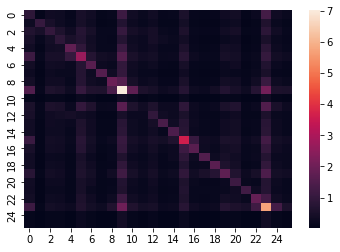

In [31]:
heatmap(globencs[0]["globenc"][24499])

<AxesSubplot:>

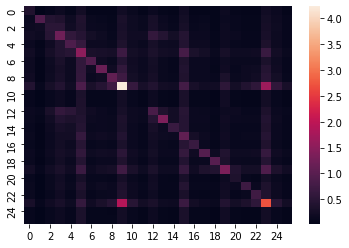

In [28]:
from seaborn import heatmap

heatmap(globencs[5]["globenc"][24499])

In [ ]:
print_globenc(globencs[i]["globenc"][idx], globencs[i]["tokens"][idx])